## Part 2 code for LLM performance evaluation 

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm

import requests
import os

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

In [3]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [4]:
# find the most common bigrams and trigrams (doubles and triple character combination)
from collections import Counter


# Ensure 'data' is defined with your full text
n = len(data)
train_chars = data[:int(n * 0.9)]
val_chars = data[int(n * 0.9):]

def BiandTrigrams(text, top=10):
    
    text = text.replace("\n", "").replace(" ", "")  # Remove spaces and newlines
    
    ngram_count = Counter()
    #pdb.st_trace()
    for size in [2,3]:
        ngrams = [text[i:i+size] for i in range(len(text) - size + 1)]
        ngram_count.update(ngrams)
    
    return [ngram for ngram, _ in ngram_count.most_common(top)]


n_biandtri = 50

out = BiandTrigrams(train_chars, n_biandtri)
#top 100 bigrams and trigrams

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))

dic = chars+list(out)

# create a mapping from dic tionary of integers and bi/trigrams to integers
stoi2 = { ch:i for i,ch in enumerate(dic) }
itos2 = { i:ch for i,ch in enumerate(dic) }

def encodeBiandTri(text):
    
    i = 0
    encoded_string = []
    while i < len(text):

        if i + 2 < len(text) and text[i:i+3] in stoi2:
            encoded_string.append(stoi2[text[i:i+3]])
            i += 3 #checks next three integers

        elif i + 1 < len(text) and text[i:i+2] in stoi2:
            encoded_string.append(stoi2[text[i:i+2]])
            i += 2
        # As above with doubles
        elif text[i] in stoi2:
            encoded_string.append(stoi2[text[i]])
            i += 1
        else:
            raise ValueError(f"Unknown token at index {i}: {text[i]}")
    return encoded_string

def decode2(l):
    return ''.join([itos2[i] for i in l]) # decoder: take a list of integers, output a string


# Encode both datasets into lists of integers
train_data = encodeBiandTri(train_chars)
val_data = encodeBiandTri(val_chars)

# Cast the lists to torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")

vocab_size=len(dic)
print(f"Dictionary has {vocab_size} tokens")




train has 796,570 tokens
val has 89,145 tokens
Dictionary has 115 tokens


In [5]:
#load GPT2-XL
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2Model.from_pretrained('gpt2-xl')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

device = torch.device("cpu")
model = model.to(device)

In [6]:
#clear MPS
import gc
torch.mps.empty_cache()
gc.collect()

4

In [7]:
#tokenize under gpt2-xl
from transformers import GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")
model = GPT2LMHeadModel.from_pretrained("gpt2-xl", torch_dtype=torch.float32)
model = model.to(device)

In [18]:

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size))) # lower diagonal matrix

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # attn_weights = torch.einsum('btd, btd -> btt', self.query(x), self.key(x)) # (B,T)
        # attn_weights = self.query(x) @ self.key(x).transpose(1,2) # (B,T,T)

        attn_weights = self.query(x) @ self.key(x).transpose(-2,-1) # (B,T,T)
        # (self.query(x) @ self.key(x).transpose(1,2)).shape # (B,T,T)
        # if len(attn_weights.shape) == 2:
        #     attn_weights = attn_weights.unsqueeze(0)
        attn_weights = attn_weights.masked_fill((self.tril==0)[0:attn_weights.shape[1],0:attn_weights.shape[2]], float('-inf')) # (B,T,T)
        attn_weights = F.softmax(attn_weights/(self.head_size**(1/2)), dim=-1) # (B,T,T)
        # if len(attn_weights.shape) == 2:
        #     avg_embeddings = torch.einsum('tt, td -> td', attn_weights, self.value(x)) #
        # else:

        # avg_embeddings = torch.einsum('btt, btd -> btd', attn_weights, self.value(x)) # (B,T,D) # self.value(x) gives (B,T,D), attn_weights gives (B,T)
        avg_embeddings = torch.einsum('bij,bjd->bid', attn_weights, self.value(x))
        return avg_embeddings


In [19]:
#Base model for non-variable attention


class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size) # X which we will pass to the head
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.atten_head = MultiHeadAttention(context_window_size, num_heads, self.head_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.vocab_size = vocab_size
      self.embed_size = embed_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below

        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) # as before

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        pass

class TransformerBlock_2(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6,dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size) # acts along rows x_t^(m+1) = mlp(y_t^(m))
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size//num_heads, embed_size) # as before
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        # for dropout

        self.dropout = nn.Dropout(dropout) # takes a dropout rate arg



    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length y_t^(m) = atten_heads(x_t^(m))
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space x_t^(m+1) = mlp(y_t^(m))



        # for adding dropout
        # x = x + self.dropout(self.atten_heads(self.ln1(x))) # communication over sequence length y_t^(m) = atten_heads(x_t^(m))
        # x = x + self.dropout(self.feed_forward(self.ln2(x))) # communication across embedding space x_t^(m+1) = mlp(y_t^(m))
        return x
class TransformerLM_2(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock_2(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)]) # chains output of one block to input of next. Output of self.blocks is x_t^M

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.vocab_size = vocab_size

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        x = self.blocks(x) # instead of just x=self.attention_head(x), x is processed through a sequence of transformer blocks, each first processed by "self attn" then by mlp.
        # this x is x_t^M in Scott's notes
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) # as before


        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate

        """
        # if token_ids.shape[0] ==1:
        #     token_ids = token_ids.unsqueeze(0)
        #     token_ids = token_ids.unsqueeze(0)

        for i in range(max_new_tokens):
            B, T = token_ids.shape # (batch size, length)
            t = min(CONTEXT_WINDOW_SIZE,T)
            tok_emb = self.token_embedding_table(token_ids[:,-t:]).reshape(B,t,-1) # (B,T,D)
            pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (T,D)
            x = tok_emb + pos_emb # (B,T,D)
            x = self.blocks(x) # (B,T,D)
            x= self.ln_f(x)
            logits = self.lm_head(x) # (B,T,V)
            # if len(logits.shape) == 2:
            #     new_token = torch.argmax(logits[-1,:])
            # else:
            #     new_token = torch.argmax(logits[:,-1],dim=1)
            # new_token = torch.argmax(logits[:,-1],dim=1) # best token for each batch
            new_token = torch.distributions.Categorical(logits=logits[:,-1]).sample()
            # token_ids = torch.cat([token_ids,new_token.unsqueeze(0)],dim=1)
            token_ids = torch.cat([token_ids,new_token.unsqueeze(1)],dim=1)

    # return decode(token_ids.tolist())
        return token_ids
        # pass

In [20]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_window_size, num_heads, head_size, embed_size=384):
        """
        Args:
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, number of heads (H)
            head_size: int, size of the head embedding dimension
            embed_size: int, size of the token embedding dimension
        """
        super().__init__()
        # TODO, your code below
        self.heads = nn.ModuleList([Head(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        self.num_heads = num_heads

        # could also learn a map from the concatenated heads to the output space ?



    def forward(self, x): # x is (B,T,D)
        # TODO, your code below
        heads = [head(x) for head in self.heads] # list of (B,T,D)
        # approach 1
        avg_embeddings = torch.stack(heads).sum(dim=0) # (B,T,D) - just sum across heads elementwise for each token
        return avg_embeddings
        # pass
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size) # acts along rows x_t^(m+1) = mlp(y_t^(m))
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size//num_heads, embed_size) # as before
        self.vocab_size = vocab_size
        self.embed_size = embed_size


    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length y_t^(m) = atten_heads(x_t^(m))

        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space x_t^(m+1) = mlp(y_t^(m))
        #print(f"Before ln1: {x.shape}, {x.dtype}")

        return x

In [21]:
#Model for var attn
class MaskedHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)
        self.z = nn.Parameter(torch.randn(1)) # learnable parameter controlling attention span
        # come back to this, not sure what the best way to initialize this is
        self.R = 10
        self.S = 100
        self.lambda_reg = 0#1e-20
        self.cached_mask = None
        self.cached_T = None
        # self.cached_z = None

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size))) # lower diagonal matrix



    def compute_masking_matrix(self, z, R, T):
        if self.cached_mask is not None and self.cached_T == T and torch.allclose(self.cached_z, z):
            return self.cached_mask

        positions = torch.arange(T, device=z.device)
        distance_matrix = positions.unsqueeze(1) - positions.unsqueeze(0)
        distance_matrix = distance_matrix.abs()  # Make sure to take the absolute value

        # Correctly implement m_z(x) = min[max[1/R(R + z - x), 0], 1]
        mask = (1 / R) * (R + z - distance_matrix)
        mask = torch.clamp(mask, min=0, max=1)

        self.cached_mask = mask
        self.cached_T = T
        self.cached_z = z.detach().clone()

        return mask  # Shape: (T, T)

    def masked_attention(self, attn_scores):
        B, T, _ = attn_scores.shape
        mask = self.compute_masking_matrix(self.z, self.R, T).unsqueeze(0)

        # For values where mask is 0, we want to ensure they get no attention
        # Setting the log probability to -inf before softmax achieves this
        log_mask = torch.log(mask.clamp(min=1e-10))
        masked_scores = attn_scores + log_mask
        attn_probs = torch.softmax(masked_scores, dim=-1)

        return attn_probs


    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """

        attn_weights = self.query(x) @ self.key(x).transpose(-2,-1) # (B,T,T)

        attn_weights = attn_weights.masked_fill((self.tril==0)[0:attn_weights.shape[1],0:attn_weights.shape[2]], float('-inf')) # (B,T,T)
        masked_attn_weights = self.masked_attention(attn_weights)
        avg_embeddings = torch.einsum('bij,bjd->bid', masked_attn_weights, self.value(x))
        l1_penalty = self.lambda_reg * self.z.abs().sum()

        return avg_embeddings,l1_penalty


class MultiHeadAttention_Masked(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_window_size, num_heads, head_size, embed_size=384):
        """
        Args:
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, number of heads (H)
            head_size: int, size of the head embedding dimension
            embed_size: int, size of the token embedding dimension
        """
        super().__init__()
        # TODO, your code below
        # had to change to module list bc l1_penalty now
        self.heads = nn.ModuleList([MaskedHead(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        self.num_heads = num_heads


    def forward(self, x): # x is (B,T,D)
        # TODO, your code below
        heads = [head(x) for head in self.heads] # list of (B,T,D)
        # approach 1
        avg_embeddings = torch.stack([h[0] for h in heads]).sum(dim=0) # (B,T,D) - just sum across heads elementwise for each token
        total_l1_penalty = sum(h[1] for h in heads) / self.num_heads  # Average L1 across heads

        return avg_embeddings, total_l1_penalty
        # pass
class TransformerBlock_VarAttn(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6,dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size) # acts along rows x_t^(m+1) = mlp(y_t^(m))
        self.atten_heads = MultiHeadAttention_Masked(context_window_size, num_heads, embed_size//num_heads, embed_size) # as before
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        # for dropout

        self.dropout = nn.Dropout(dropout) # takes a dropout rate arg



    def forward(self, x):
        attn_output, l1_penalty = self.atten_heads(self.ln1(x))
        x = x + self.dropout(attn_output)
        x = x + self.dropout(self.feed_forward(self.ln2(x)))
        return x, l1_penalty

class TransformerLM_VarAttn(nn.Module):
    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        # module list again bc l1_penalty
        self.blocks = nn.ModuleList([
            TransformerBlock_VarAttn(vocab_size, context_window_size, embed_size=embed_size, num_heads=num_heads)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.vocab_size = vocab_size

        # Good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Args:
            token_ids: (B, T) tensor of integers, provides the context
            targets: (B, T) tensor of integers, provides the tokens we are predicting
        """
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)  # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=token_ids.device))  # (T, D)
        x = tok_emb + pos_emb  # (B, T, D)

        total_l1_penalty = 0
        # does the sequential processing manually since using module list instead of sequential
        for block in self.blocks:
            x, l1_penalty = block(x)
            total_l1_penalty += l1_penalty

        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) + total_l1_penalty

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: (B, T) tensor of integers forming the context.
            max_new_tokens: int, max number of tokens to generate.
        """
        for i in range(max_new_tokens):
            B, T = token_ids.shape  # (B, T)
            t = min(T, self.position_embedding_table.num_embeddings)
            tok_emb = self.token_embedding_table(token_ids[:, -t:]).reshape(B, t, -1)  # (B, T, D)
            pos_emb = self.position_embedding_table(torch.arange(t, device=token_ids.device))  # (T, D)
            x = tok_emb + pos_emb  # (B, T, D)
            for block in self.blocks:
                x, _ = block(x)
            x = self.ln_f(x)
            logits = self.lm_head(x)  # (B, T, V)
            new_token = torch.distributions.Categorical(logits=logits[:, -1]).sample()
            token_ids = torch.cat([token_ids, new_token.unsqueeze(1)], dim=1)
        return token_ids


In [22]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)]) # chains output of one block to input of next. Output of self.blocks is x_t^M

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.vocab_size = vocab_size

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        x = self.blocks(x) # instead of just x=self.attention_head(x), x is processed through a sequence of transformer blocks, each first processed by "self attn" then by mlp.
        # this x is x_t^M in Scott's notes
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) # as before


        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate

        """
        # if token_ids.shape[0] ==1:
        #     token_ids = token_ids.unsqueeze(0)
        #     token_ids = token_ids.unsqueeze(0)
        #print(token_ids)
        for i in range(max_new_tokens):
            B, T = token_ids.shape # (batch size, length)
            t = min(CONTEXT_WINDOW_SIZE,T)
            #print(t)
            tok_emb = self.token_embedding_table(token_ids[:,-t:]).reshape(B,t,-1) # (B,T,D)
            pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (T,D)
            x = tok_emb + pos_emb # (B,T,D)
            #print(x.shape)

            x = self.blocks(x) # (B,T,D)
            x= self.ln_f(x)

            logits = self.lm_head(x) # (B,T,V)
            # if len(logits.shape) == 2:
            #     new_token = torch.argmax(logits[-1,:])
            # else:
            #     new_token = torch.argmax(logits[:,-1],dim=1)
            # new_token = torch.argmax(logits[:,-1],dim=1) # best token for each batch
            new_token = torch.distributions.Categorical(logits=logits[:,-1]).sample()
            # token_ids = torch.cat([token_ids,new_token.unsqueeze(0)],dim=1)
            token_ids = torch.cat([token_ids,new_token.unsqueeze(1)],dim=1)

    # return decode(token_ids.tolist())
        return token_ids
        # pass

In [23]:
#if model is variable attention
checkpoint = torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/Baseline_model.pth",
                       map_location=torch.device('cpu'))
#update model name for loading

trans = checkpoint["model"]
loss_list = checkpoint["loss_list"]
# Set the model to evaluation mode 
# trans.eval()

# If using a GPU, move the model to the device (e.g., CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trans.to(device)

tlm = trans.to("cpu")

/var/folders/52/w3mmgby125s0y29t28_yzw540000gn/T/ipykernel_2604/2768099232.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/Users/ldavis2000/Doc

In [24]:
# Remaking the training and test splits for security
n = len(data)
train_chars = data[:int(n*0.9)]
val_chars = data[int(n*0.9):]

# encode both to integers
train_data = encodeBiandTri(train_chars)
val_data = encodeBiandTri(val_chars)

# cast as torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

In [25]:
#logits function calculator
def logits(context: str, predicted: str):

    #Encoding inputs
    context_tokens = tokenizer.encode(context, add_special_tokens=False)
    pred_tokens = tokenizer.encode(predicted, add_special_tokens=False)

    # Combine context and predicted tokens
    input_tokens = context_tokens + pred_tokens
    input_tensor = torch.tensor([input_tokens])
    input_tensor = input_tensor.to("cpu")
    
    
    #logits output no autograd for mem
    with torch.no_grad():
        outputs = model(input_tensor)
        logits = outputs.logits  

    #logits for the predicted tokens
    
    pred_logits = logits[0, -len(pred_tokens)-1:-1, :]

    return pred_logits, pred_tokens  

context = "The quick brown fox"
predicted = "jump overs the lazy dogg"
truth = "jumps over the lazy dog"

logits_out_truth, logits_out_tokens = logits(context, truth)

#logits_out_pred = logits(context,predicted)

In [26]:
import random

#context_chars-decode2(pred_output)
def pred_par_only(s1, s2):

    for i in range(len(s1)):
        if s2.startswith(s1[i:]):  
            return s2[len(s1[i:]):]  
    return s2  

N_rep = 10 #number of repeated simulations

con_length = 100 #context length of 100

pred_length = 20 #length of predicted output

#context is given in integers

#using 20 different contexts

con_start = 5000*torch.arange(20)

mean = []

for i1 in con_start:
    
    context_chars = val_chars[i1:(i1+con_length)] #is a string
    
    context = torch.tensor(encodeBiandTri(context_chars)).reshape(1,-1)
    #is tokens in tensor
    
    mean_start = []
    
    for j1 in range(N_rep):
        
        pred_output = (tlm.generate(context, max_new_tokens=pred_length)[0].tolist())
        #test is just context and outputs 50 tokens
        
        predicted_extra = pred_par_only(context_chars, decode2(pred_output))
        #only the generated text
        
        pred_text = predicted_extra[:pred_length]
        #generated text of 50 characters
        
        encode_pred_text = encodeBiandTri(pred_text)
        #encoding above to integers
        
        #new_element = (torch.tensor([[encode_pred_text]])
        #turning to torch tensor
        
        logits_inner = []
        
        for i in range(len(encode_pred_text)-1):
            
            pred_context = decode2(encode_pred_text[0:(i+1)])
            #previous context to predict on
                                   
            context_chars_tmp = context_chars + pred_context
            
            #to predict is next character
            
            pred_logits, pred_tokens = logits(context_chars_tmp,\
                                              decode2(encode_pred_text[(i+1):(i+2)]))
            #predicted xtra only to first 50 characters
            
            logits_inner.append((pred_logits[:,pred_tokens].squeeze(1))[0])

            #tmp = torch.tensor([pred_logits[idx,token].item() for idx, token in enumerate(pred_tokens)])
        
        first_elements = [t[0].item() if t.numel() > 1 else t.item() for t in logits_inner]
        
        mean_start.append(torch.tensor(first_elements).mean()) 
        #means of tokens we use
        
    mean.append(torch.tensor(mean_start).mean())
        
    print(f"Finished 25 trials at {i1}") 

Finished 25 trials at 0
Finished 25 trials at 5000
Finished 25 trials at 10000
Finished 25 trials at 15000
Finished 25 trials at 20000
Finished 25 trials at 25000
Finished 25 trials at 30000
Finished 25 trials at 35000
Finished 25 trials at 40000
Finished 25 trials at 45000
Finished 25 trials at 50000
Finished 25 trials at 55000
Finished 25 trials at 60000
Finished 25 trials at 65000
Finished 25 trials at 70000
Finished 25 trials at 75000
Finished 25 trials at 80000
Finished 25 trials at 85000
Finished 25 trials at 90000
Finished 25 trials at 95000


In [27]:
##UPDATE FILE NAME TO SAVE CORRECTLY after compuatation
mean_base = torch.tensor(mean).clone()

#from google.colab import files
# Save tensor
torch.save(mean_base, "/Users/ldavis2000/Documents/Winter Quarter/305B/base_means_new.pth")


In [28]:
#load data 
var_means_0_attn =torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/0_var_means_new.pth")

mean_var_attn_50 =torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/50_var_means_new.pth")

mean_var_attn_100 =torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/100_var_means_new.pth")

mean_var_attn_250 =torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/250_var_means_new.pth")

mean_reg_attn_50 = torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/50_Attn_means_new.pth")

mean_reg_attn_100 = torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/100_Attn_means_new.pth")

mean_reg_attn_250 = torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/250_Attn_means_new.pth")

mean_base_load = torch.load("/Users/ldavis2000/Documents/Winter Quarter/305B/base_means_new.pth")

/var/folders/52/w3mmgby125s0y29t28_yzw540000gn/T/ipykernel_3633/2625887310.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  var_means_0_attn =torch.load("/Users/ldavis200

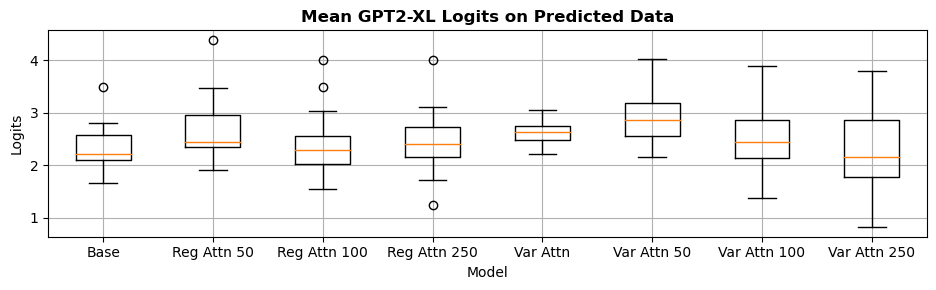

In [27]:
import matplotlib.pyplot as plt

#to update
pred_tensors_total = [mean_base_load,mean_reg_attn_50,mean_reg_attn_100,mean_reg_attn_250,
                      var_means_0_attn,mean_var_attn_50,mean_var_attn_100,mean_var_attn_250]

data = [t.tolist() for t in pred_tensors_total]

fig, ax = plt.subplots(figsize=(12, 3))
box = plt.boxplot(data, patch_artist=False)


legend_labels = ['Base', 'Reg Attn 50', 'Reg Attn 100',
                 'Reg Attn 250','Var Attn', 'Var Attn 50', 'Var Attn 100', 'Var Attn 250']
ax.set_xticks(range(1, 8+1))
ax.set_xticklabels(legend_labels)
ax.grid()



plt.xlabel("Model")
plt.ylabel("Logits")
plt.title("Mean GPT2-XL Logits on Predicted Data", fontweight="bold")


plt.tight_layout(rect=[0, 0, 0.8, 1]) 


plt.savefig("GPTLogits.png", dpi=600, bbox_inches="tight")
plt.show()


In [32]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = {
    "ModelSize": ["base", "base", "50", "50", "100", "100", "250", "250"],
    "VarAttention": [0, 1, 0, 1, 0, 1, 0,1],
    "Logits": [float(mean_base_load),float(var_means_0_attn),float(mean_reg_attn_50),float(mean_var_attn_50),
              float(mean_reg_attn_100),float(mean_var_attn_100),float(mean_reg_attn_250),float(mean_var_attn_250)]
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert categorical variables
df["ModelSize"] = df["ModelSize"].astype("category")
df["VarAttention"] = df["VarAttention"].astype("category")

# Fit Two-Way ANOVA model
model = smf.ols("Logits ~ C(ModelSize) + C(VarAttention) + C(ModelSize):C(VarAttention)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print ANOVA table
print(anova_table)


ValueError: only one element tensors can be converted to Python scalars

In [33]:
mean_base_load

tensor([2.0856, 2.2239, 2.5666, 2.1195, 2.4029, 1.6839, 2.6417, 2.1999, 2.7874,
        2.0976, 2.1047, 1.6660, 3.4938, 1.9579, 1.7235, 2.8108, 2.1577, 2.6914,
        2.3444, 2.5079])

In [39]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

logit_tensors = {
    "base_0": mean_base_load.tolist(),
    "base_1": var_means_0_attn.tolist(),
    "50_0": mean_reg_attn_50.tolist(),
    "50_1": mean_var_attn_50.tolist(),
    "100_0": mean_reg_attn_100.tolist(),
    "100_1": mean_var_attn_100.tolist(),
    "250_0": mean_reg_attn_250.tolist(),
    "250_1": mean_var_attn_250.tolist()
}

data = []
for key, logits in logit_tensors.items():
    model_size, var_attention = key.split("_") 
    for logit in logits:
        data.append({"ModelSize": model_size, "VarAttention": int(var_attention), "Logits": logit})

df = pd.DataFrame(data)


df["ModelSize"] = df["ModelSize"].astype("category")
df["VarAttention"] = df["VarAttention"].astype("category")

model = smf.ols("Logits ~ C(ModelSize) + C(VarAttention) + C(ModelSize):C(VarAttention)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(model.summary())
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:                 Logits   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.647
Date:                Fri, 14 Mar 2025   Prob (F-statistic):             0.0133
Time:                        11:18:15   Log-Likelihood:                -126.89
No. Observations:                 150   AIC:                             269.8
Df Residuals:                     142   BIC:                             293.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------